In [1]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
path_to_cellnumber_data = '../data/full_with_cellnumber/RFQopt_model_01_Dataset_05_217k-samples.txt'
cellnumber_data_file = open(path_to_cellnumber_data, 'r')
lines = cellnumber_data_file.readlines()

lines_split = [re.split('\s+', s) for s in lines][:-1]
assert(all([len(lines_split[i]) == 23 for i in range(len(lines_split))]))

In [3]:
columns = lines_split[0]
data_raw = lines_split[1:]

In [4]:
data_dict = {col: [entry[i] for entry in data_raw] for i, col in enumerate(columns) if col not in {'|', ''}}
data_df = pd.DataFrame(data_dict)
data_df = data_df.apply(pd.to_numeric)

x_df = data_df[['Bmax', 'mX1', 'mX2', 'mY1', 'mY2', 'mtau1', 'mtau2', 'PhiY1', 'PhiY2',
       'Phitau1', 'Phitau2', 'mY3ref', 'PhiY3ref', 'Eref']]
y_df = data_df[['Transmission',
       'Length', 'Energy', '#Cells', 'E_Long', 'E_X', 'E_Y']]

/var/folders/03/b5tt622d05n71qt51ysytbyc0000gq/T/ipykernel_92589/3350420050.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/var/folders/03/b5tt622d05n71qt51ysytbyc0000gq/T/ipykernel_92589/3350420050.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


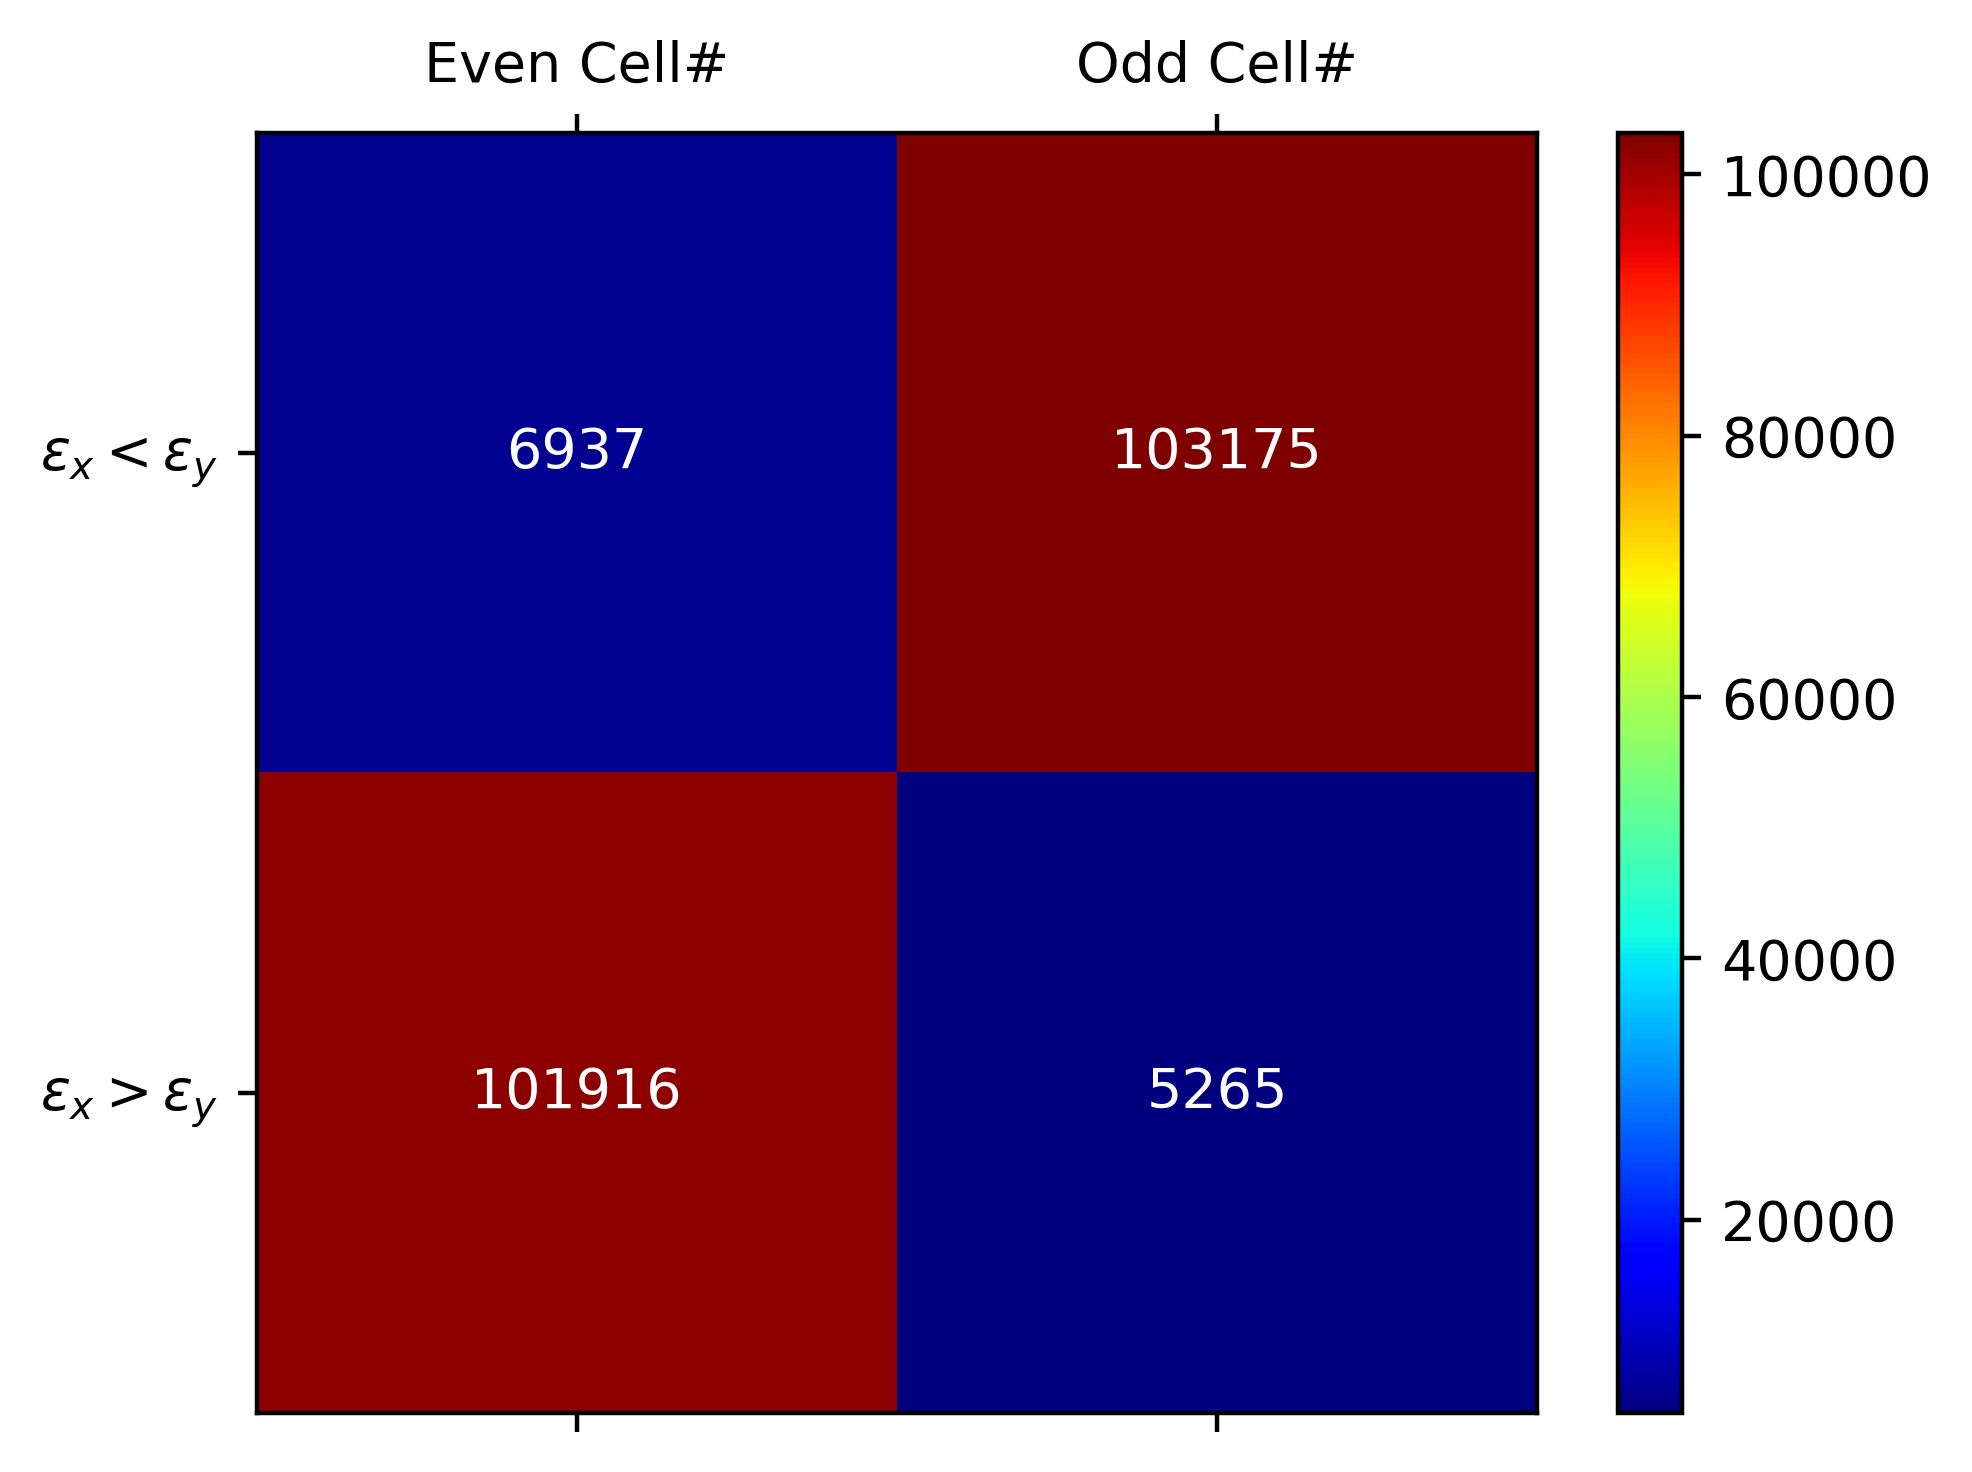

In [5]:
# confusion matrix
cm = confusion_matrix(y_df['E_X'] > y_df['E_Y'], y_df['#Cells'] % 2)

fig, ax = plt.subplots(dpi=400)
cax = ax.matshow(cm, cmap='jet')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Even Cell#'
labels[2] = 'Odd Cell#'
ax.set_xticklabels(labels)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '$\epsilon_x < \epsilon_y$'
labels[2] = '$\epsilon_x > \epsilon_y$'
ax.set_yticklabels(labels)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
fig.colorbar(cax)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center', color='white')

plt.show()

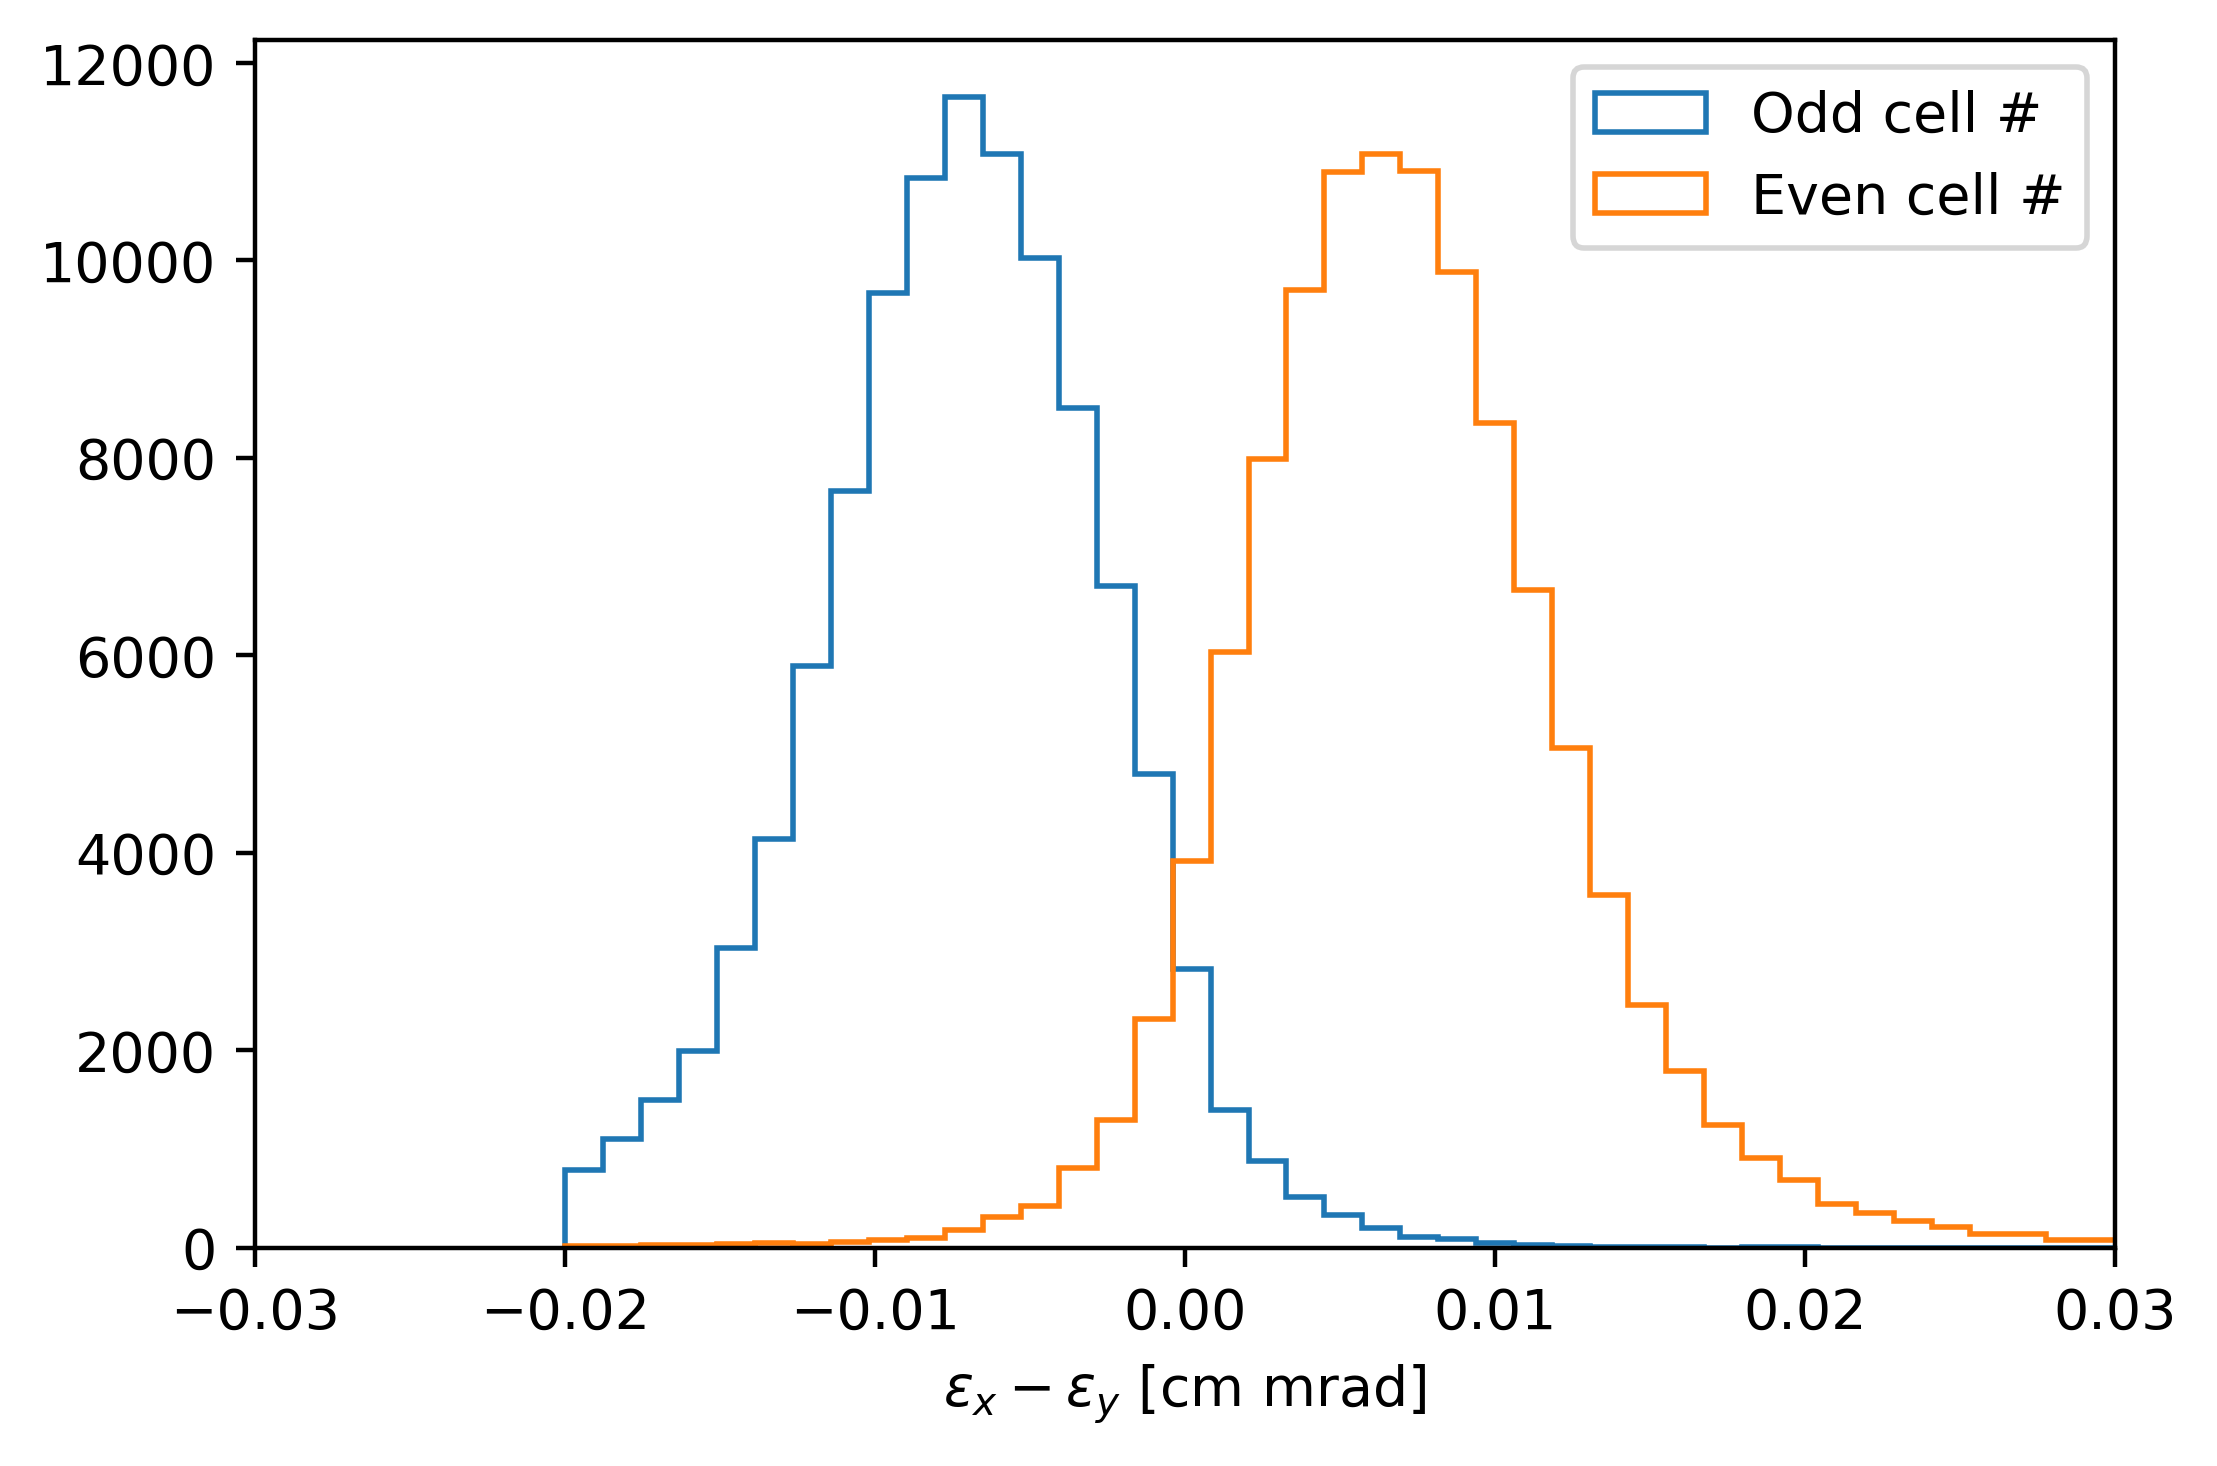

In [8]:
# histograms of emittance difference distributions
fig, ax = plt.subplots(dpi=400)

odd_df = y_df.loc[(y_df['#Cells'] % 2) == 1]
even_df = y_df.loc[(y_df['#Cells'] % 2) == 0]

bins = np.linspace(-0.02, 0.04, 50)

ax.hist(odd_df['E_X'] - odd_df['E_Y'], label='Odd cell #', bins=bins, histtype='step')
ax.hist((even_df['E_X'] - even_df['E_Y']).values, label='Even cell #', bins=bins, histtype='step')
plt.legend()

ax.set_xlabel('$\epsilon_x - \epsilon_y$ [cm mrad]')
ax.set_xlim(-0.03, 0.03)

plt.savefig("../img/oddevenemittance.png", dpi=400)

In [126]:
# read in old data
target_directory = '../data/full_opt_15KeV'

x_dictlist, y_dictlist = [], []

for json_file in os.listdir(target_directory):
    if json_file[-4:] != 'json':
        continue

    with open(f'{target_directory}/{json_file}') as f:
        samples = json.load(f)['samples']
        dvars = [samples[i]['dvar'] for i in samples.keys()]
        objs = [samples[i]['obj'] for i in samples.keys()]
        
        x_dictlist += dvars
        y_dictlist += objs
        
x_old_df = pd.DataFrame(x_dictlist).apply(pd.to_numeric)
y_old_df = pd.DataFrame(y_dictlist).apply(pd.to_numeric)

features_dict = {
    "DVAR1": "Bmax",
    "DVAR2": "mX1",
    "DVAR3": "mX2",
    "DVAR4": "mY1",
    "DVAR5": "mY2",
    "DVAR6": "mtau1",
    "DVAR7": "mtau2",
    "DVAR8": "PhiY1",
    "DVAR9": "PhiY2",
    "DVAR10": "Phitau1",
    "DVAR11": "Phitau2",
    "DVAR12": "mY3ref",
    "DVAR13": "PhiY3ref",
    "DVAR14": "Eref",
}

response_dict = {
    "OBJ1": "Transmission",
    "OBJ2": "Energy",
    "OBJ3": "Length",
    "OBJ4": "E_Long",
    "OBJ5": "E_X",
    "OBJ6": "E_Y",
}

x_old_df = x_old_df.rename(columns=features_dict)
y_old_df = y_old_df.rename(columns=response_dict)

In [130]:
# compare distributions -- make sure that data is the same
from scipy.stats import ks_2samp

print("-- x --")
for xcol in x_old_df.columns:
    old_data = x_old_df[xcol]
    new_data = x_df[xcol]
    
    print(xcol, ks_2samp(old_data, new_data))
    
print("\n-- y --")
for ycol in y_old_df.columns:
    old_data = y_old_df[ycol]
    new_data = y_df[ycol]
    print(ycol, ks_2samp(old_data, new_data))

-- x --
Bmax KstestResult(statistic=2.7612486366290767e-05, pvalue=1.0)
mX1 KstestResult(statistic=1.3806243183200895e-05, pvalue=1.0)
mX2 KstestResult(statistic=1.3806243183256406e-05, pvalue=1.0)
mY1 KstestResult(statistic=5.06228916716811e-05, pvalue=1.0)
mY2 KstestResult(statistic=5.5224972732692557e-05, pvalue=1.0)
mtau1 KstestResult(statistic=9.20416212213393e-06, pvalue=1.0)
mtau2 KstestResult(statistic=9.20416212213393e-06, pvalue=1.0)
PhiY1 KstestResult(statistic=1.3806243183256406e-05, pvalue=1.0)
PhiY2 KstestResult(statistic=1.840832424426786e-05, pvalue=1.0)
Phitau1 KstestResult(statistic=9.20416212213393e-06, pvalue=1.0)
Phitau2 KstestResult(statistic=9.20416212213393e-06, pvalue=1.0)
mY3ref KstestResult(statistic=6.903121591583794e-05, pvalue=1.0)
PhiY3ref KstestResult(statistic=1.840832424426786e-05, pvalue=1.0)
Eref KstestResult(statistic=0.0003773706470065752, pvalue=1.0)

-- y --
Transmission KstestResult(statistic=-0.0, pvalue=1.0)
Energy KstestResult(statistic=-0.0,

134